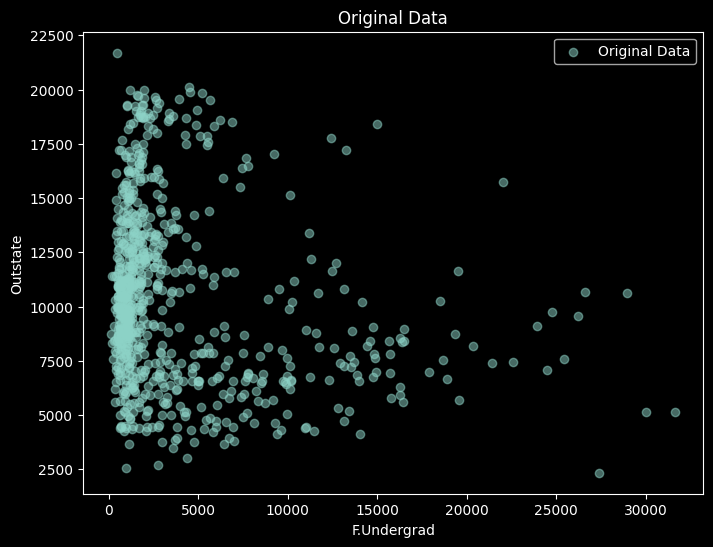

In [6]:
# 데이터 로드 및 전처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 불러오기
data = pd.read_csv('C:/Users/bikmi/Desktop/Bigdata_HW/HW6/College.csv')

# 결측값 제거
target = 'Outstate'  # 종속 변수
feature = 'F.Undergrad'  # 독립 변수
cleaned_data = data[[feature, target]].dropna()
X = cleaned_data[[feature]].values
y = cleaned_data[target].values

# 원본 데이터 시각화
plt.figure(figsize=(8, 6))
plt.scatter(X, y, alpha=0.5, label='Original Data')
plt.xlabel(feature)
plt.ylabel(target)
plt.title('Original Data')
plt.legend()
plt.show()


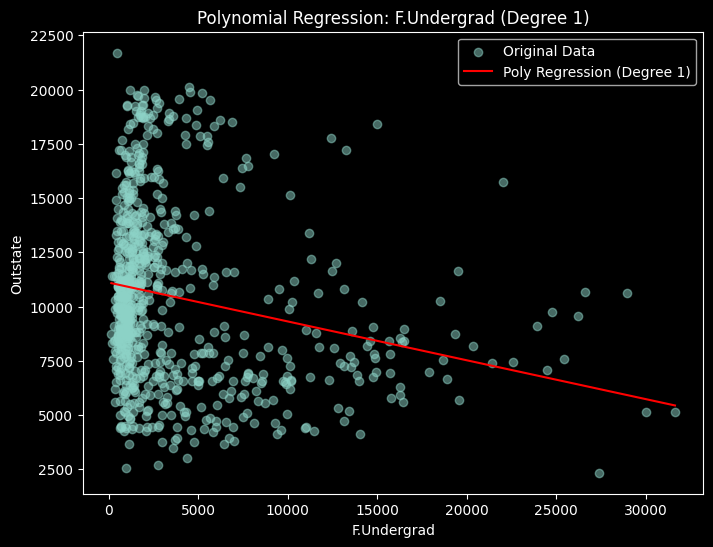

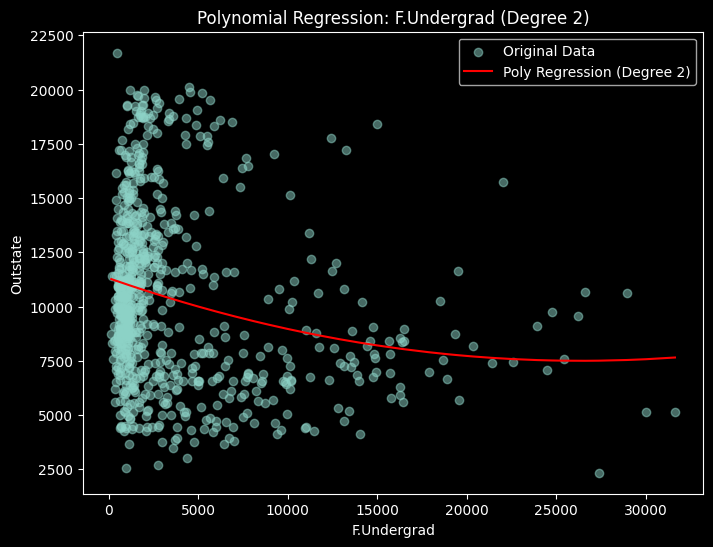

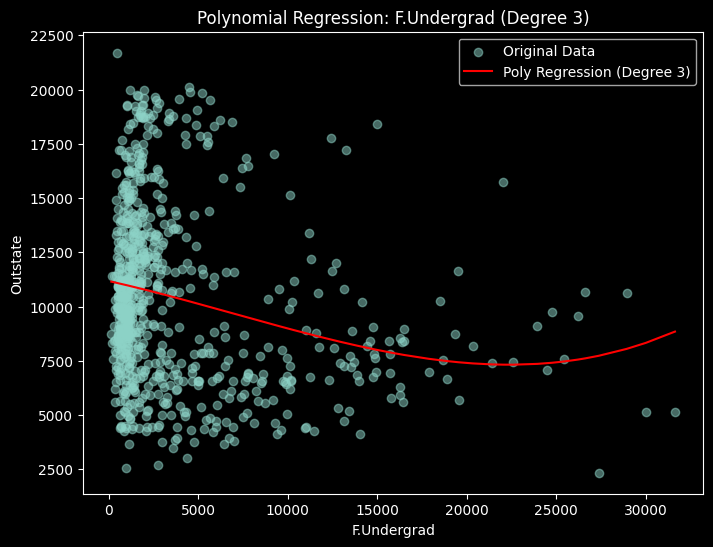

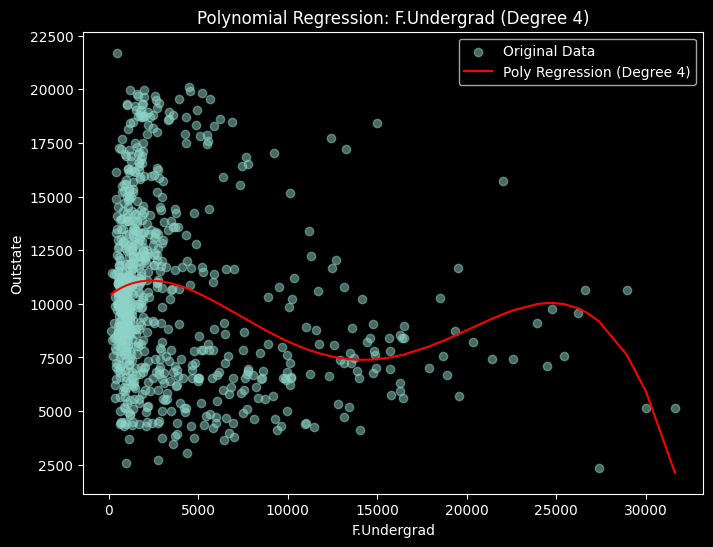

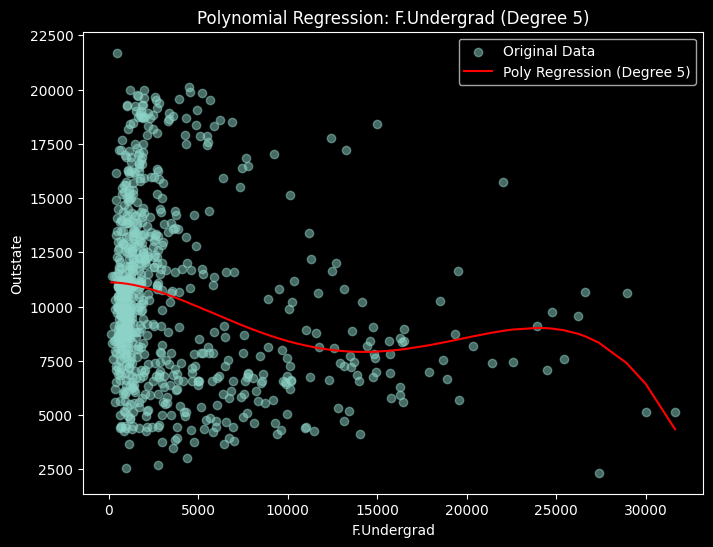

     variables  degree           mse        r2
3  F.Undergrad       4  1.508095e+07  0.066994
4  F.Undergrad       5  1.519134e+07  0.060165
2  F.Undergrad       3  1.535409e+07  0.050096
1  F.Undergrad       2  1.536448e+07  0.049453
0  F.Undergrad       1  1.541149e+07  0.046545


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from itertools import combinations

# 데이터 준비
data = cleaned_data  # 결측값 제거된 데이터
target = 'Outstate'  # 종속 변수
independent_vars = [col for col in data.columns if col != target]  # 독립 변수 리스트
max_degree = 5  # 다항식 최대 차수

# 결과 저장
results = []

# 모든 독립 변수 및 변수 조합에 대해 다항 회귀 실행
for num_vars in range(1, len(independent_vars) + 1):  # 변수 조합 크기(1개부터 모든 변수)
    for var_combination in combinations(independent_vars, num_vars):  # 변수 조합 생성
        X = data[list(var_combination)].values
        y = data[target].values
        
        for degree in range(1, max_degree + 1):  # 다항식 차수
            poly = PolynomialFeatures(degree=degree)
            X_poly = poly.fit_transform(X)
            
            # 모델 학습
            model = LinearRegression()
            model.fit(X_poly, y)
            
            # 예측 및 성능 평가
            y_pred = model.predict(X_poly)
            mse = mean_squared_error(y, y_pred)
            r2 = r2_score(y, y_pred)
            
            # 결과 저장
            results.append({
                'variables': ', '.join(var_combination),
                'degree': degree,
                'mse': mse,
                'r2': r2
            })
            
            # 시각화 (2D 데이터만 시각화 가능)
            if len(var_combination) == 1:  # 독립 변수가 하나일 때만 그래프 생성
                plt.figure(figsize=(8, 6))
                plt.scatter(X, y, alpha=0.5, label='Original Data')
                plt.plot(
                    np.sort(X, axis=0),
                    model.predict(poly.fit_transform(np.sort(X, axis=0))),
                    label=f'Poly Regression (Degree {degree})',
                    color='red'
                )
                plt.xlabel(var_combination[0])
                plt.ylabel(target)
                plt.title(f'Polynomial Regression: {var_combination[0]} (Degree {degree})')
                plt.legend()
                plt.show()

# 결과를 DataFrame으로 정리
results_df = pd.DataFrame(results)

# 상위 모델 확인 (예: R^2 기준으로 정렬)
results_df = results_df.sort_values(by='r2', ascending=False)

# 결과 출력
print(results_df)

# CSV 파일 저장
results_df.to_csv('polynomial_regression_results.csv', index=False)


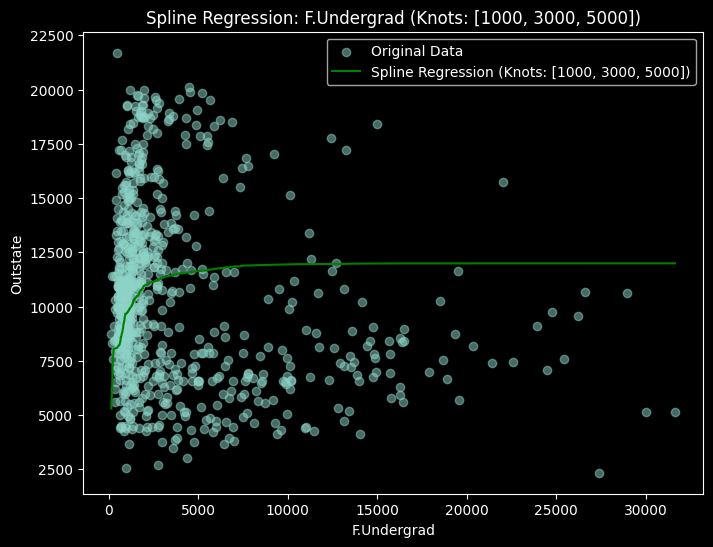

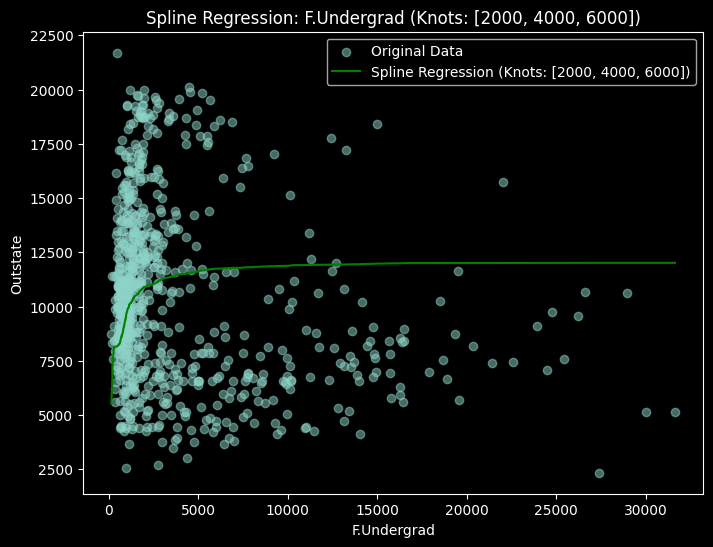

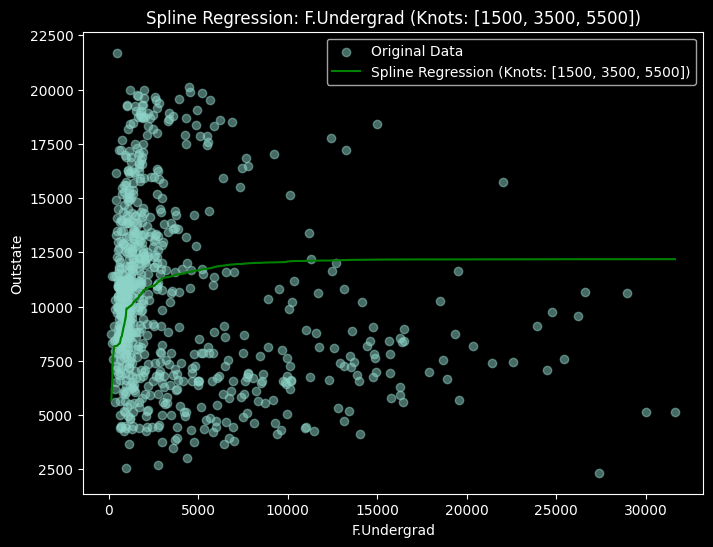

Top 10 Results:
        variables  variable_index               knots           mse        r2
2  (F.Undergrad,)               0  [1500, 3500, 5500]  1.459445e+07  0.097092
0  (F.Undergrad,)               0  [1000, 3000, 5000]  1.462720e+07  0.095066
1  (F.Undergrad,)               0  [2000, 4000, 6000]  1.466625e+07  0.092650


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrix
from statsmodels.api import GLM
from statsmodels.genmod.families import Gaussian
from itertools import combinations

# 데이터 준비
data = cleaned_data  # 결측값 제거된 데이터
target = 'Outstate'  # 종속 변수
independent_vars = [col for col in data.columns if col != target]  # 독립 변수 리스트

# 노드 설정
knots_list = [[1000, 3000, 5000], [2000, 4000, 6000], [1500, 3500, 5500]]  # 다양한 노드 설정

# 결과 저장
results = []

# 모든 독립 변수 및 변수 조합에 대해 스플라인 회귀 실행
for num_vars in range(1, len(independent_vars) + 1):  # 변수 조합 크기(1개부터 모든 변수)
    for var_combination in combinations(independent_vars, num_vars):  # 변수 조합 생성
        X = data[list(var_combination)].values
        y = data[target].values
        
        for knots in knots_list:  # 다양한 노드 조합에 대해 반복
            for i in range(X.shape[1]):  # 변수 개수만큼 반복
                # 스플라인 설계 행렬 생성
                spline_basis = dmatrix(
                    f"bs(x, knots={knots}, degree=3, include_intercept=False)",
                    {"x": X[:, i].flatten()},
                    return_type="dataframe"
                )
                
                # 스플라인 회귀 모델
                spline_model = GLM(y, spline_basis, family=Gaussian()).fit()
                y_spline_pred = spline_model.predict(spline_basis)
                
                # 모델 성능 평가
                mse = np.mean((y - y_spline_pred) ** 2)
                r2 = 1 - (np.sum((y - y_spline_pred) ** 2) / np.sum((y - np.mean(y)) ** 2))
                
                # 결과 저장
                results.append({
                    'variables': var_combination,
                    'variable_index': i,
                    'knots': knots,
                    'mse': mse,
                    'r2': r2
                })
                
                # 시각화 (2D 데이터만 시각화 가능)
                if len(var_combination) == 1:  # 독립 변수가 하나일 때만 그래프 생성
                    plt.figure(figsize=(8, 6))
                    plt.scatter(X[:, i], y, alpha=0.5, label='Original Data')
                    plt.plot(
                        np.sort(X[:, i], axis=0),
                        np.sort(y_spline_pred, axis=0),
                        label=f'Spline Regression (Knots: {knots})',
                        color='green'
                    )
                    plt.xlabel(var_combination[i])
                    plt.ylabel(target)
                    plt.title(f'Spline Regression: {var_combination[i]} (Knots: {knots})')
                    plt.legend()
                    plt.show()

# 결과를 DataFrame으로 정리
results_df = pd.DataFrame(results)

# 상위 모델 확인 (예: R^2 기준으로 정렬)
results_df = results_df.sort_values(by='r2', ascending=False)

# 모든 경우의 수를 CSV로 저장
results_df.to_csv('spline_regression_results.csv', index=False)

# 결과 출력
print("Top 10 Results:")
print(results_df.head(10))


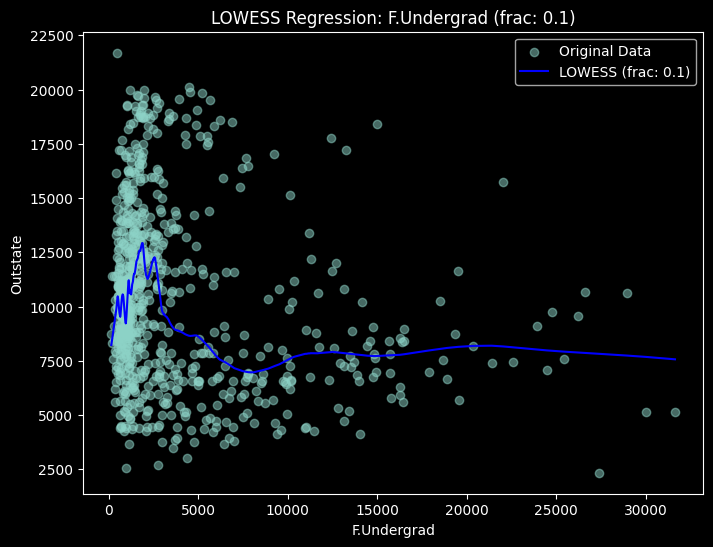

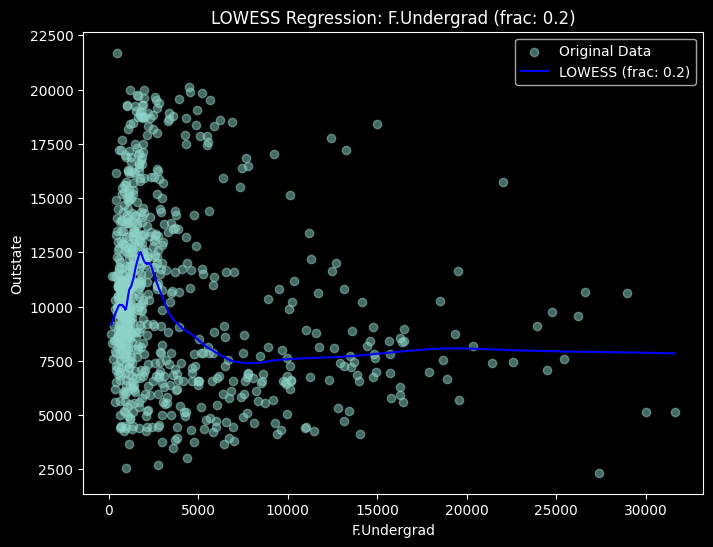

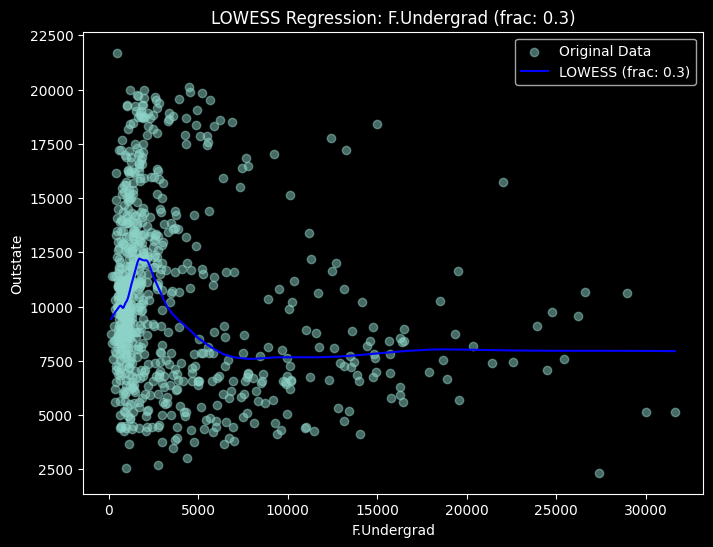

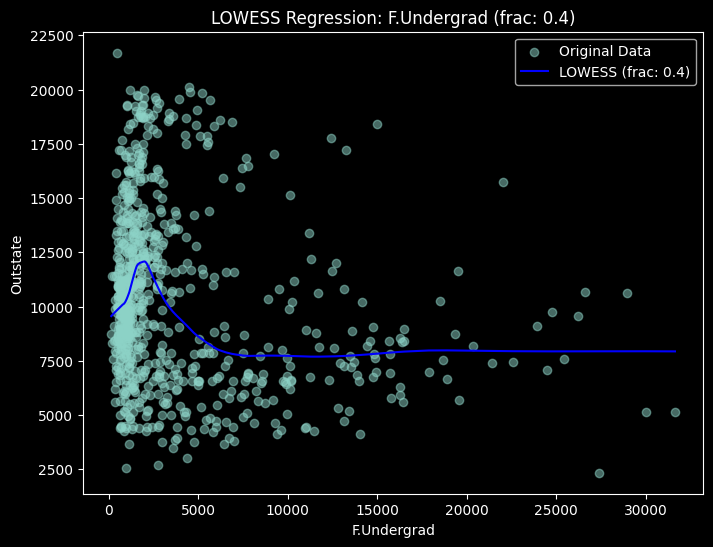

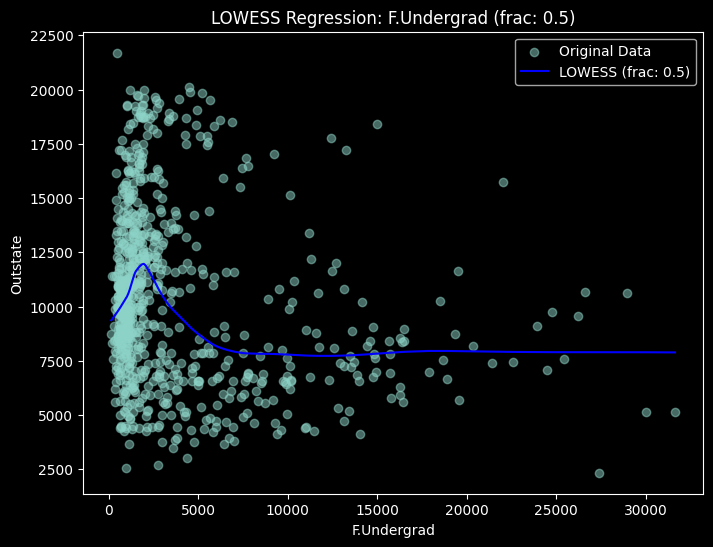

Top 10 Results:
        variables  variable_index  frac           mse        r2
0  (F.Undergrad,)               0   0.1  1.455611e+07  0.099464
4  (F.Undergrad,)               0   0.5  1.476067e+07  0.086809
3  (F.Undergrad,)               0   0.4  1.476573e+07  0.086495
1  (F.Undergrad,)               0   0.2  1.477102e+07  0.086169
2  (F.Undergrad,)               0   0.3  1.479040e+07  0.084969


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score

# 데이터 준비
data = cleaned_data  # 결측값 제거된 데이터
target = 'Outstate'  # 종속 변수
independent_vars = [col for col in data.columns if col != target]  # 독립 변수 리스트

# LOWESS 매개변수 설정
frac_values = [0.1, 0.2, 0.3, 0.4, 0.5]  # 다양한 데이터 비율 설정

# 결과 저장
results = []

# 모든 독립 변수 및 변수 조합에 대해 LOWESS 회귀 실행
for num_vars in range(1, len(independent_vars) + 1):  # 변수 조합 크기(1개부터 모든 변수)
    for var_combination in combinations(independent_vars, num_vars):  # 변수 조합 생성
        X = data[list(var_combination)].values
        y = data[target].values
        
        for frac in frac_values:  # 다양한 frac 값에 대해 반복
            for i in range(X.shape[1]):  # 각 독립 변수에 대해 실행
                # LOWESS 회귀 실행
                lowess_result = lowess(y, X[:, i].flatten(), frac=frac)
                
                # 예측값 생성
                y_lowess_pred = np.interp(X[:, i].flatten(), lowess_result[:, 0], lowess_result[:, 1])
                
                # 성능 평가
                mse = mean_squared_error(y, y_lowess_pred)
                r2 = 1 - (np.sum((y - y_lowess_pred) ** 2) / np.sum((y - np.mean(y)) ** 2))
                
                # 결과 저장
                results.append({
                    'variables': var_combination,
                    'variable_index': i,
                    'frac': frac,
                    'mse': mse,
                    'r2': r2
                })
                
                # 시각화 (2D 데이터만 시각화 가능)
                if len(var_combination) == 1:  # 독립 변수가 하나일 때만 그래프 생성
                    plt.figure(figsize=(8, 6))
                    plt.scatter(X[:, i], y, alpha=0.5, label='Original Data')
                    plt.plot(lowess_result[:, 0], lowess_result[:, 1], label=f'LOWESS (frac: {frac})', color='blue')
                    plt.xlabel(var_combination[i])
                    plt.ylabel(target)
                    plt.title(f'LOWESS Regression: {var_combination[i]} (frac: {frac})')
                    plt.legend()
                    plt.show()

# 결과를 DataFrame으로 정리
results_df = pd.DataFrame(results)

# 상위 모델 확인 (예: R^2 기준으로 정렬)
results_df = results_df.sort_values(by='r2', ascending=False)

# 모든 경우의 수를 CSV로 저장
results_df.to_csv('lowess_regression_results.csv', index=False)

# 결과 출력
print("Top 10 Results:")
print(results_df.head(10))


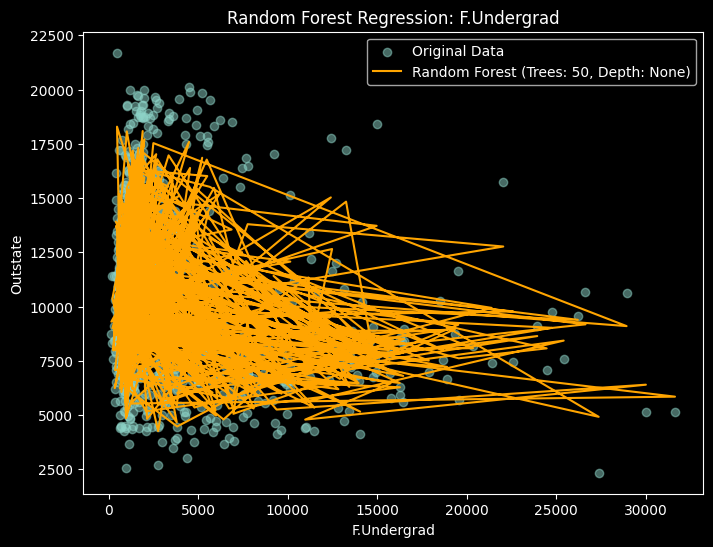

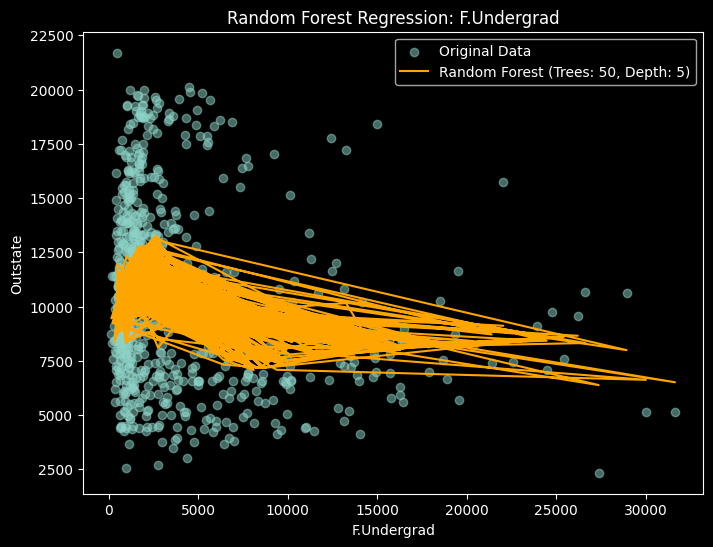

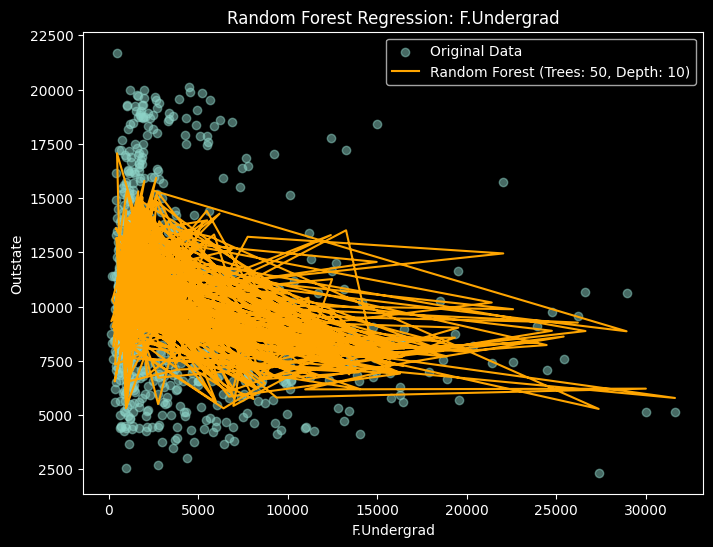

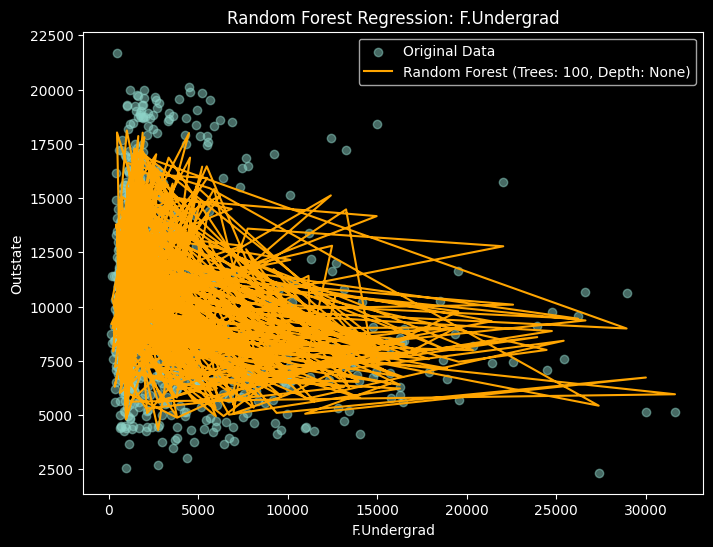

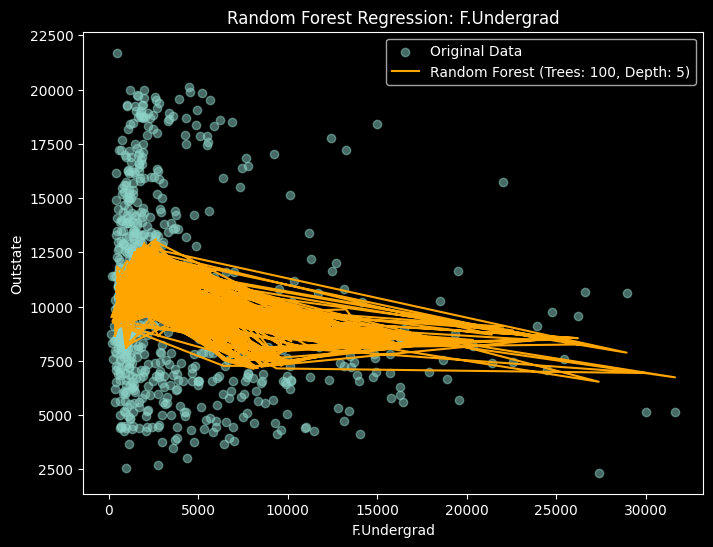

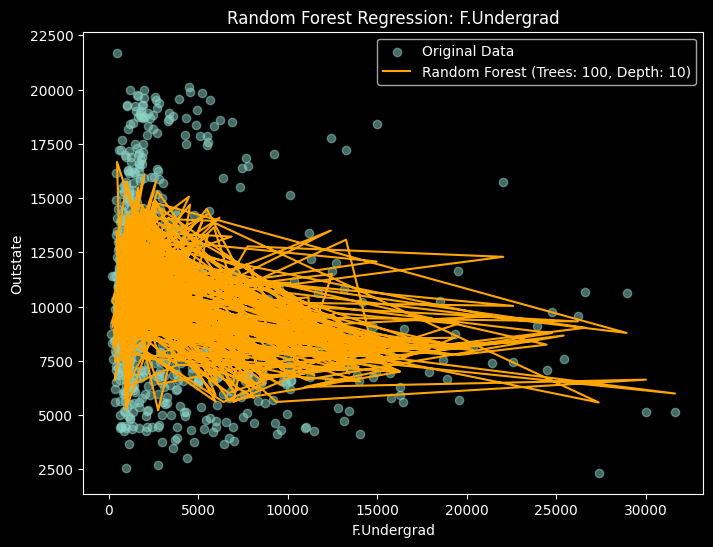

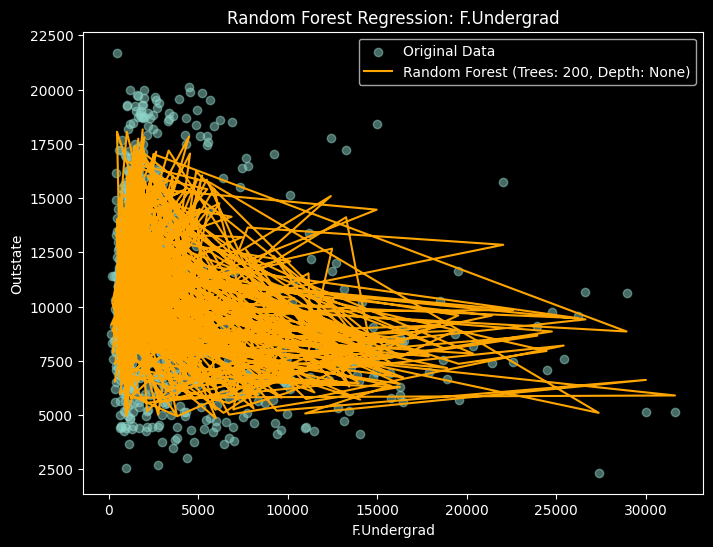

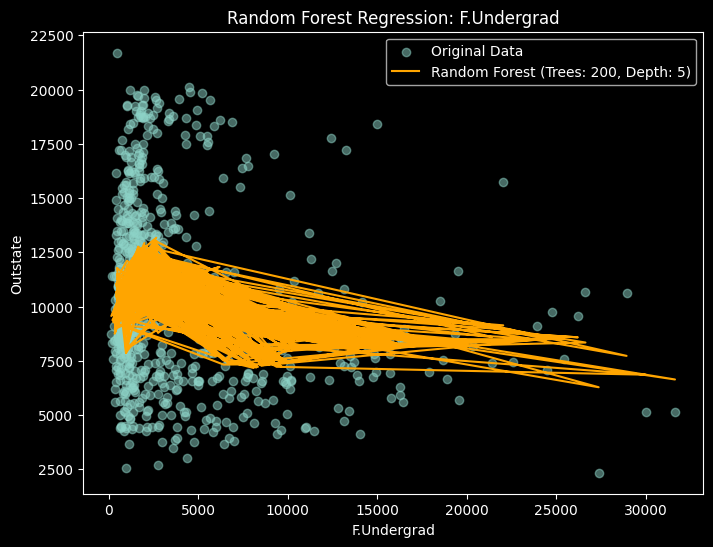

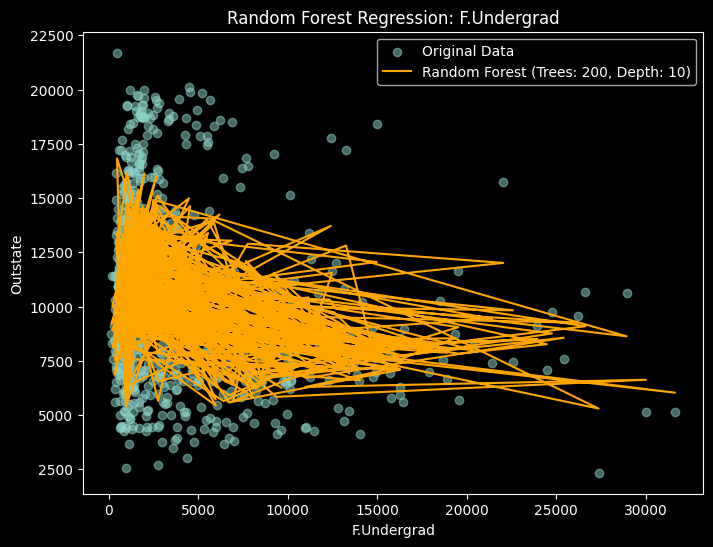

Top 10 Results:
        variables  n_estimators  max_depth           mse        r2
6  (F.Undergrad,)           200        NaN  3.476493e+06  0.784922
3  (F.Undergrad,)           100        NaN  3.521318e+06  0.782148
0  (F.Undergrad,)            50        NaN  3.565860e+06  0.779393
8  (F.Undergrad,)           200       10.0  7.174045e+06  0.556167
5  (F.Undergrad,)           100       10.0  7.199233e+06  0.554609
2  (F.Undergrad,)            50       10.0  7.251598e+06  0.551369
7  (F.Undergrad,)           200        5.0  1.237195e+07  0.234591
4  (F.Undergrad,)           100        5.0  1.238879e+07  0.233549
1  (F.Undergrad,)            50        5.0  1.239166e+07  0.233371


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 데이터 준비
data = cleaned_data  # 결측값 제거된 데이터
target = 'Outstate'  # 종속 변수
independent_vars = [col for col in data.columns if col != target]  # 독립 변수 리스트

# 랜덤 포레스트 매개변수 설정
n_estimators_values = [50, 100, 200]  # 트리 개수
max_depth_values = [None, 5, 10]  # 트리 최대 깊이

# 결과 저장
results = []

# 모든 독립 변수 및 변수 조합에 대해 랜덤 포레스트 회귀 실행
for num_vars in range(1, len(independent_vars) + 1):  # 변수 조합 크기(1개부터 모든 변수)
    for var_combination in combinations(independent_vars, num_vars):  # 변수 조합 생성
        X = data[list(var_combination)].values
        y = data[target].values
        
        for n_estimators in n_estimators_values:  # 트리 개수 조합
            for max_depth in max_depth_values:  # 최대 깊이 조합
                # 랜덤 포레스트 회귀 모델
                rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
                rf_model.fit(X, y)
                y_rf_pred = rf_model.predict(X)
                
                # 성능 평가
                mse = mean_squared_error(y, y_rf_pred)
                r2 = r2_score(y, y_rf_pred)
                
                # 결과 저장
                results.append({
                    'variables': var_combination,
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'mse': mse,
                    'r2': r2
                })
                
                # 시각화 (2D 데이터만 시각화 가능)
                if len(var_combination) == 1:  # 독립 변수가 하나일 때만 그래프 생성
                    plt.figure(figsize=(8, 6))
                    plt.scatter(X, y, alpha=0.5, label='Original Data')
                    plt.plot(X, y_rf_pred, label=f'Random Forest (Trees: {n_estimators}, Depth: {max_depth})', color='orange')
                    plt.xlabel(var_combination[0])
                    plt.ylabel(target)
                    plt.title(f'Random Forest Regression: {var_combination[0]}')
                    plt.legend()
                    plt.show()

# 결과를 DataFrame으로 정리
results_df = pd.DataFrame(results)

# 상위 모델 확인 (예: R^2 기준으로 정렬)
results_df = results_df.sort_values(by='r2', ascending=False)

# 모든 경우의 수를 CSV로 저장
results_df.to_csv('random_forest_regression_results.csv', index=False)

# 결과 출력
print("Top 10 Results:")
print(results_df.head(10))


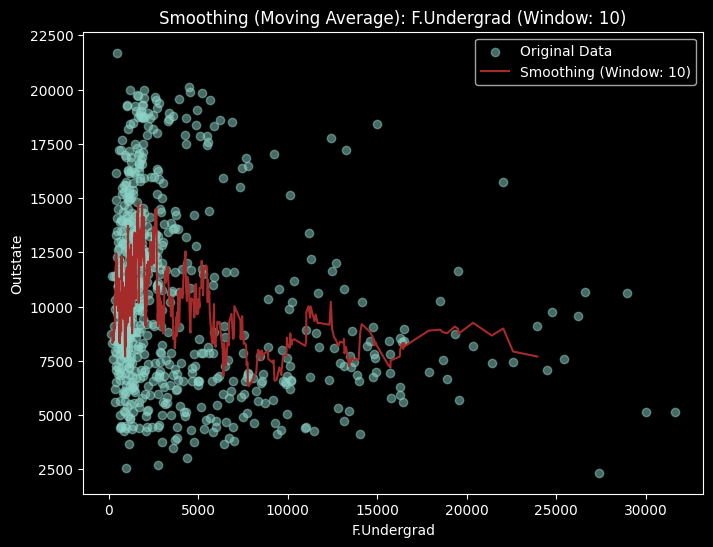

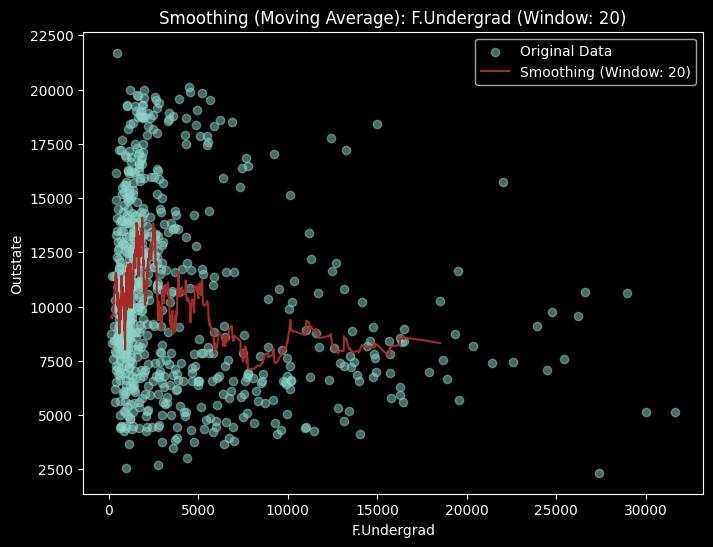

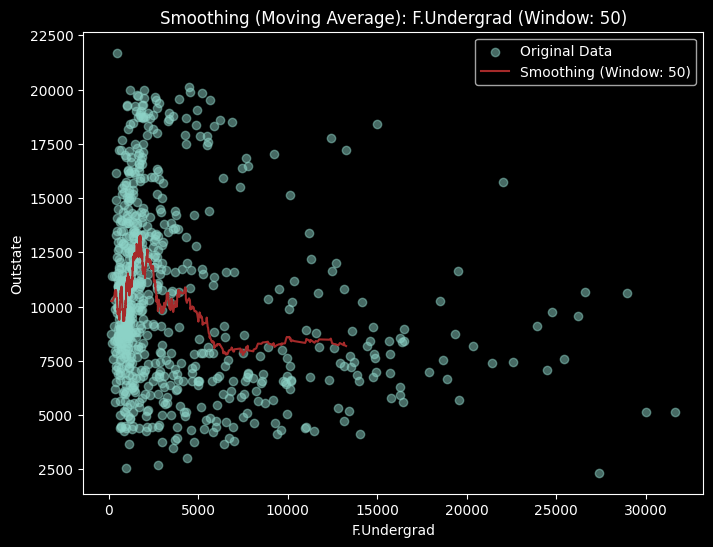

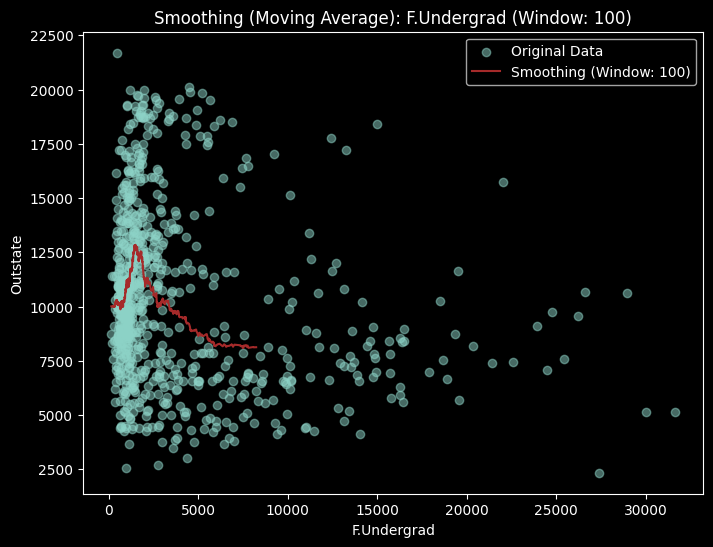

Top 10 Results:
        variables  variable_index  window_size           mse        r2
0  (F.Undergrad,)               0           10  1.318652e+07  0.184196
1  (F.Undergrad,)               0           20  1.398796e+07  0.134614
2  (F.Undergrad,)               0           50  1.452890e+07  0.101147
3  (F.Undergrad,)               0          100  1.477286e+07  0.086055


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score

# 데이터 준비
data = cleaned_data  # 결측값 제거된 데이터
target = 'Outstate'  # 종속 변수
independent_vars = [col for col in data.columns if col != target]  # 독립 변수 리스트

# 윈도우 크기 설정
window_sizes = [10, 20, 50, 100]  # 다양한 윈도우 크기

# 스무딩 함수
def smoothing(X, y, window_size):
    sorted_indices = np.argsort(X.flatten())
    X_sorted = X.flatten()[sorted_indices]
    y_sorted = y[sorted_indices]
    smoothed_y = np.convolve(y_sorted, np.ones(window_size)/window_size, mode='valid')
    smoothed_x = X_sorted[:len(smoothed_y)]
    return smoothed_x, smoothed_y

# 결과 저장
results = []

# 모든 독립 변수 및 변수 조합에 대해 스무딩 적용
for num_vars in range(1, len(independent_vars) + 1):  # 변수 조합 크기(1개부터 모든 변수)
    for var_combination in combinations(independent_vars, num_vars):  # 변수 조합 생성
        X = data[list(var_combination)].values
        y = data[target].values
        
        for window_size in window_sizes:  # 다양한 윈도우 크기에 대해 반복
            for i in range(X.shape[1]):  # 각 독립 변수에 대해 실행
                # 스무딩 적용
                smoothed_x, smoothed_y = smoothing(X[:, i], y, window_size=window_size)
                
                # 예측값 생성 및 성능 평가
                y_pred = np.interp(X[:, i], smoothed_x, smoothed_y, left=smoothed_y[0], right=smoothed_y[-1])
                mse = mean_squared_error(y, y_pred)
                r2 = r2_score(y, y_pred)
                
                # 결과 저장
                results.append({
                    'variables': var_combination,
                    'variable_index': i,
                    'window_size': window_size,
                    'mse': mse,
                    'r2': r2
                })
                
                # 시각화 (2D 데이터만 시각화 가능)
                if len(var_combination) == 1:  # 독립 변수가 하나일 때만 그래프 생성
                    plt.figure(figsize=(8, 6))
                    plt.scatter(X[:, i], y, alpha=0.5, label='Original Data')
                    plt.plot(smoothed_x, smoothed_y, label=f'Smoothing (Window: {window_size})', color='brown')
                    plt.xlabel(var_combination[0])
                    plt.ylabel(target)
                    plt.title(f'Smoothing (Moving Average): {var_combination[0]} (Window: {window_size})')
                    plt.legend()
                    plt.show()

# 결과를 DataFrame으로 정리
results_df = pd.DataFrame(results)

# 상위 모델 확인 (예: R^2 기준으로 정렬)
results_df = results_df.sort_values(by='r2', ascending=False)

# 모든 경우의 수를 CSV로 저장
results_df.to_csv('moving_average_smoothing_results.csv', index=False)

# 결과 출력
print("Top 10 Results:")
print(results_df.head(10))
